In [1]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

from tensorflow.keras.models import load_model, Model


C:\Users\HP\AppData\Roaming\Python\Python313\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
def r2_metric(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred))
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - ss_res / (ss_tot + tf.keras.backend.epsilon())


In [3]:
model = load_model(
    "dependables/cnn_image_model.keras",
    custom_objects={"r2_metric": r2_metric}
)

last_conv_layer = None
for layer in reversed(model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv_layer = layer
        break

print("Last Conv layer:", last_conv_layer.name)

inputs = tf.keras.Input(shape=(224, 224, 3))

x = inputs
conv_output = None

for layer in model.layers:
    x = layer(x)
    if layer == last_conv_layer:
        conv_output = x

# x is now the final output
grad_model = Model(inputs=inputs, outputs=[conv_output, x])

grad_model.summary()


Last Conv layer: conv2d_23


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,377 (364.75 KB)

 Trainable params: 93,377 (364.75 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
def load_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = img / 255.0
    return np.expand_dims(img, axis=0)

img_path = "satellite_images/00025.jpg"
img_array = load_image(img_path)


In [5]:
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(img_array)
    loss = predictions[:, 0]

grads = tape.gradient(loss, conv_outputs)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

conv_outputs = conv_outputs[0]
heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)

heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap) + 1e-8


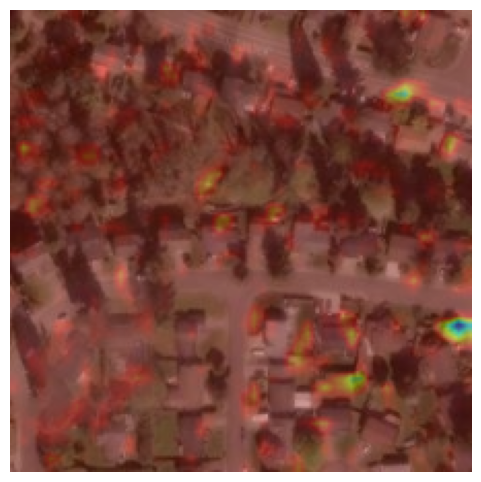

In [6]:
def overlay_heatmap(img_path, heatmap, alpha=0.4):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))

    heatmap = cv2.resize(heatmap, (224, 224))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    overlay = cv2.addWeighted(img, 1 - alpha, heatmap, alpha, 0)

    plt.figure(figsize=(6, 6))
    plt.imshow(overlay)
    plt.axis("off")
    plt.show()

overlay_heatmap(img_path, heatmap)


Grad-CAM for 00010.jpg


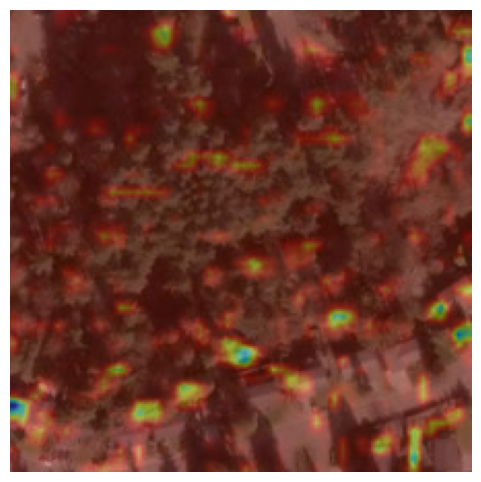

Grad-CAM for 00025.jpg


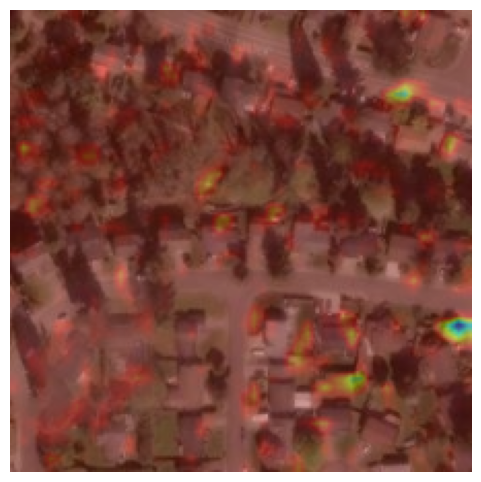

Grad-CAM for 00100.jpg


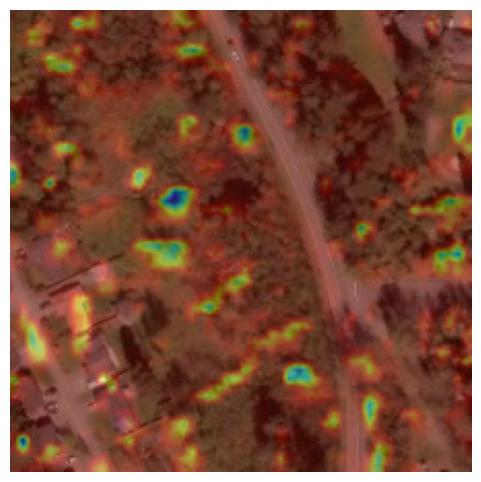

In [7]:
image_ids = ["00010.jpg", "00025.jpg", "00100.jpg"]

for img_name in image_ids:
    img_path = f"satellite_images/{img_name}"
    
    img_array = load_image(img_path)

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)

    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) + 1e-8

    print(f"Grad-CAM for {img_name}")
    overlay_heatmap(img_path, heatmap)


In [ ]:
                                                            #SHAP

In [8]:
import pandas as pd
import numpy as np
import shap
import xgboost as xgb

from sklearn.model_selection import train_test_split


In [10]:
df = pd.read_csv("dependables/feature_CNN.csv")

X = df.drop(columns=["price", "imageid"], errors="ignore")
y = df["price"]

cnn_cols = [c for c in X.columns if c.startswith("cnn_")]
print("CNN feature count:", len(cnn_cols))


CNN feature count: 128


In [11]:
model = xgb.XGBRegressor(
    n_estimators=600,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=600,
             n_jobs=-1, num_parallel_tree=None, ...)

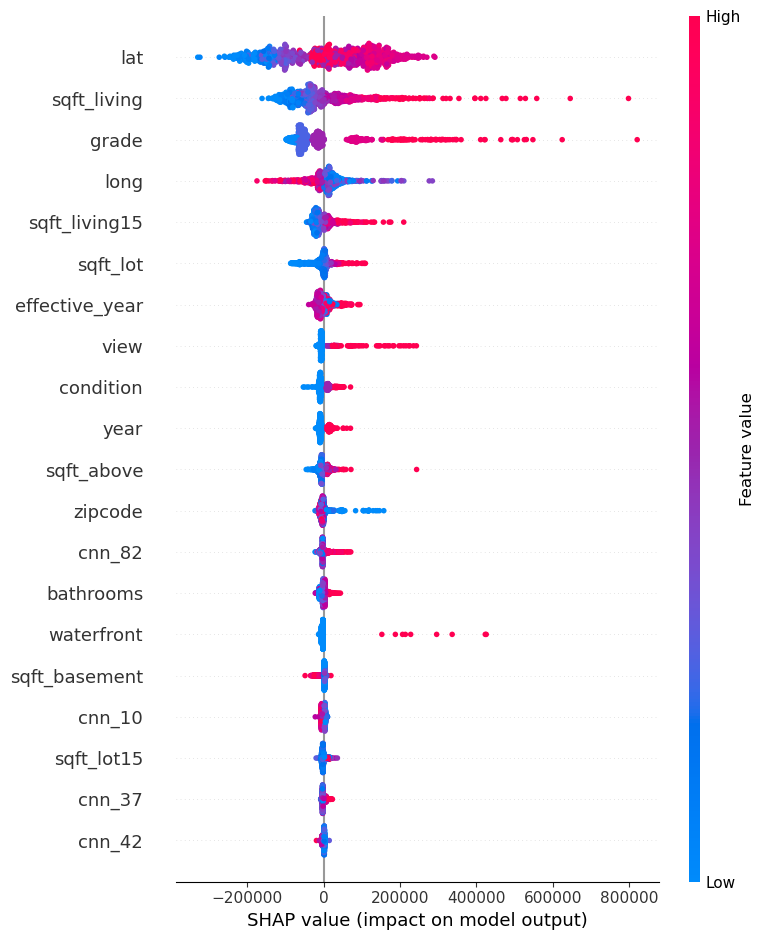

In [12]:
explainer = shap.TreeExplainer(model)

X_sample = X_val.sample(1000, random_state=42)

shap_values = explainer.shap_values(X_sample)

shap.summary_plot(shap_values, X_sample)


In [13]:
top_features = pd.Series(
    np.abs(shap_values).mean(axis=0),
    index=X_sample.columns
).sort_values(ascending=False)

top_features.head(20)



lat               105111.937500
sqft_living        69967.117188
grade              69088.671875
long               30621.892578
sqft_living15      20037.107422
sqft_lot           16229.719727
effective_year     13576.325195
view               13029.666016
condition          12005.977539
year               11261.742188
sqft_above          9878.619141
zipcode             8664.126953
cnn_82              6602.157715
bathrooms           5055.532715
waterfront          4993.902832
sqft_basement       4928.500000
cnn_10              3998.334473
sqft_lot15          3611.078369
cnn_37              3581.346924
cnn_42              2614.592773
dtype: float32

In [14]:
cnn_importance = top_features[cnn_cols].sum()
tab_importance = top_features.drop(cnn_cols).sum()

print("CNN contribution %:", cnn_importance / (cnn_importance + tab_importance))
print("Tabular contribution %:", tab_importance / (cnn_importance + tab_importance))


CNN contribution %: 0.20949732
Tabular contribution %: 0.79050267


In [15]:
cnn_only = top_features[cnn_cols].sort_values(ascending=False).head(15)
cnn_only

cnn_82     6602.157715
cnn_10     3998.334473
cnn_37     3581.346924
cnn_42     2614.592773
cnn_34     2500.331787
cnn_44     2207.625488
cnn_12     2054.695557
cnn_0      2020.125732
cnn_49     1946.388916
cnn_63     1772.644165
cnn_114    1670.062500
cnn_59     1659.773926
cnn_71     1653.554321
cnn_75     1508.733154
cnn_115    1486.928101
dtype: float32